# Comparing beamconv's TOD with analytical formula

In this script, we check that the TOD returned by beamconv overlaps with the analytical formula (no beam 
convolution)

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp

In [2]:
nside = 16
npix = 12*nside**2
lmax = 2*nside
mmax = lmax

pix = hp.ang2pix(nside, np.pi/2, 0) # pixel corresponding to a point on the equator
co_lat = hp.pix2ang(nside, pix)[0]  # co-latitude at the pixel's center
lon = hp.pix2ang(nside, pix)[1]     # longitude at the pixel's center

fwhm_arcmin = 5
fwhm_rad = fwhm_arcmin/60/180*np.pi
blm = hp.blm_gauss(fwhm_rad, lmax=lmax, pol = True)

In [3]:
def fill_alm(alm, lmax, mmax):    
    # returns same as bml, but full alm_size
    alm_size = hp.Alm.getsize(lmax, mmax=mmax)
    alm_full = np.zeros((3,alm_size), dtype = np.complex128)

    idx_start = hp.Alm.getidx(lmax,0,0)
    idx_stop  = hp.Alm.getidx(lmax,lmax,0)
    alm_full[0,idx_start:idx_stop] = alm[0][idx_start:idx_stop]

    idx_start = hp.Alm.getidx(lmax,2,2)
    idx_stop = hp.Alm.getidx(lmax,lmax,2)
    alm_full[1,idx_start:idx_stop] = -alm[1][idx_start:idx_stop]
    alm_full[2,idx_start:idx_stop] = -alm[2][idx_start:idx_stop]
    
    return alm_full

bmap = hp.alm2map(fill_alm(blm,lmax=lmax,mmax=mmax),nside=nside,lmax=lmax,mmax=mmax)
norm = np.sum(bmap[0])

print(norm)

217.55132609308438


In [15]:
def get_beamconv_values(lmax, fwhm_arcmin, slm, ptg, hwp_angles, mueller):
    from beamconv import Beam, ScanStrategy, tools
    import qpoint as qp

    # set up beam and HWP mueller matrix (identity, i.e. no HWP)
    beam = Beam(btype='Gaussian', fwhm=fwhm_arcmin, lmax=lmax)
    beam.hwp_mueller = mueller

    nsamp = ptg.shape[0]
    duration = 1        #scan duration in seconds
    sample_rate = nsamp #samples per second

    # from (theta,phi) to (ra,dec) convention
    # also, all angles are converted in degrees
    ra = np.degrees(ptg[:,1])
    dec = 90. - np.degrees(ptg[:,0])
    psi = np.degrees(ptg[:,2])

    # calculate the quaternion
    q_bore_array = qp.QPoint().radecpa2quat(ra, dec, psi)

    def ctime_test(**kwargs):
        start = kwargs.pop('start')
        end = kwargs.pop('end')
        nsamp = end - start
        ctime0 = 0
        ctime = ctime0 + sample_rate*np.arange(nsamp)
        return ctime
    
    def q_bore_test(**kwargs):
        start = kwargs.pop('start')
        end = kwargs.pop('end')
        return q_bore_array[start:end]
   
    S = ScanStrategy(duration=duration, sample_rate=sample_rate, external_pointing=True, use_l2_scan=False)
    S.add_to_focal_plane(beam, combine=False)
    S.set_hwp_mod(mode='stepped', freq=sample_rate, angles=hwp_angles*180/np.pi)
    S.allocate_maps(nside=nside)
    S.scan_instrument_mpi(slm, save_tod=True, ctime_func=ctime_test, q_bore_func=q_bore_test,
                      ctime_kwargs={'useless':0}, q_bore_kwargs={'useless':0})
    
    maps, cond, proj = S.solve_for_map(return_proj = True) 
    
    return S.data(S.chunks[0], beam=beam, data_type='tod').copy()

In [16]:
# set up sky alm
lmax = 2*nside
ells = np.arange(lmax+1)
cls = np.ones((4,lmax+1))

maps_pre = np.zeros((3,npix))
maps_pre[0] = 1

slm = hp.map2alm(maps_pre, lmax=lmax)
maps = hp.alm2map(slm,nside=nside)

mueller0 = np.diag([1.,1.,1.,1.])
mueller1 = np.diag([1.,1.,-1.,-1.])
mueller2 = np.asarray([[1, 1, 0, 0], [1, 1, 0, 0], [0, 0, -1, 0], [0, 0, 0, -1]], dtype=float)

nptg=1000
ptg = np.empty((nptg,3))
ptg[:,0] = co_lat         # theta
ptg[:,1] = lon            # phi
ptg[:,2] = np.zeros(nptg) # psi

pixs = hp.ang2pix(nside, ptg[:,0], ptg[:,1])

hwp_angles = (np.arange(nptg)+6)/nptg*8*np.pi  # alpha

tod0 = get_beamconv_values(lmax=lmax, fwhm_arcmin=fwhm_arcmin, slm=slm, ptg=ptg, hwp_angles=hwp_angles, mueller=mueller0)
tod1 = get_beamconv_values(lmax=lmax, fwhm_arcmin=fwhm_arcmin, slm=slm, ptg=ptg, hwp_angles=hwp_angles, mueller=mueller1)
tod2 = get_beamconv_values(lmax=lmax, fwhm_arcmin=fwhm_arcmin, slm=slm, ptg=ptg, hwp_angles=hwp_angles, mueller=mueller2)

print(tod0[0])

Scanning with 1 detectors
[rank 000]:	Working on chunk 000: samples 0-1000
(3, 3072)
Scanning with 1 detectors
[rank 000]:	Working on chunk 000: samples 0-1000
(3, 3072)
Scanning with 1 detectors
[rank 000]:	Working on chunk 000: samples 0-1000
(3, 3072)
0.9999990682366722


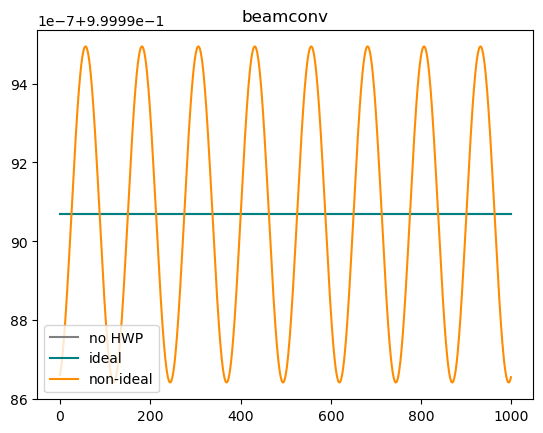

In [6]:
plt.plot(tod0, label='no HWP', color='gray')
plt.plot(tod1, label='ideal', color='teal')
plt.plot(tod2, label='non-ideal', color='darkorange')
plt.title('beamconv')
plt.legend()
plt.show()

In [7]:
def rot_mat(theta):
    c, s = np.cos(2*theta), np.sin(2*theta)
    return np.array(((1,0,0),(0,c,-s),(0,s,c)))

In [8]:
print(maps[:,pixs[0]])
stokes = hp.sphtfunc.smoothing(maps, fwhm=fwhm_rad)[:,pixs[0]]
print(stokes)

d0 = np.empty_like(tod0)
d1 = np.empty_like(tod1)
d2 = np.empty_like(tod2)

for i in np.arange(nptg):
    rot_mat_i = rot_mat(hwp_angles[i])
    stokes0 = rot_mat(0).dot(rot_mat_i.transpose().dot(mueller0[:3,:3].dot(rot_mat_i).dot(stokes)))
    d0[i] = (stokes0[0]+stokes0[1])
    stokes1 = rot_mat(0).dot(rot_mat_i.transpose().dot(mueller1[:3,:3].dot(rot_mat_i).dot(stokes)))
    d1[i] = (stokes1[0]+stokes1[1])
    stokes2 = rot_mat(0).dot(rot_mat_i.transpose().dot(mueller2[:3,:3].dot(rot_mat_i).dot(stokes)))
    d2[i] = (stokes2[0]+stokes2[1])

[0.99999937 0.         0.        ]
[0.99982714 0.         0.        ]
0.999828069320035


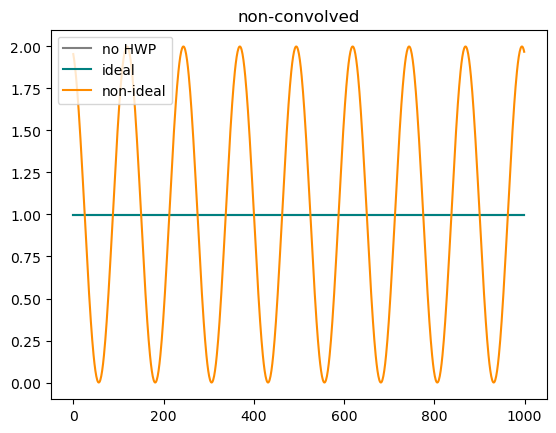

In [9]:
plt.plot(d0, label='no HWP', color='gray')
plt.plot(d1, label='ideal', color='teal')
plt.plot(d2, label='non-ideal', color='darkorange')
plt.title('non-convolved')
plt.legend()
plt.show()

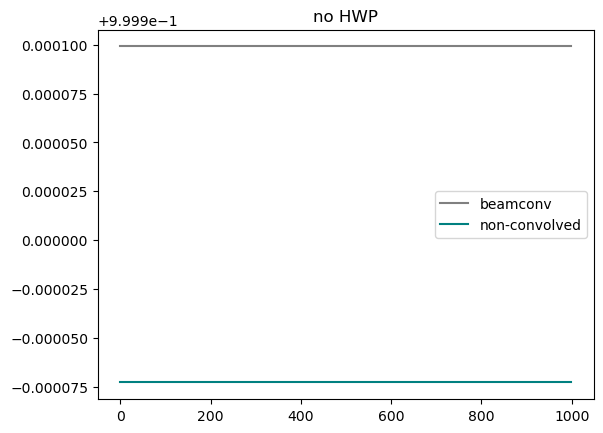

In [10]:
plt.plot(tod0, label='beamconv', color='gray')
plt.plot(d0, label='non-convolved', color='teal')
plt.title('no HWP')
plt.legend()
plt.show()

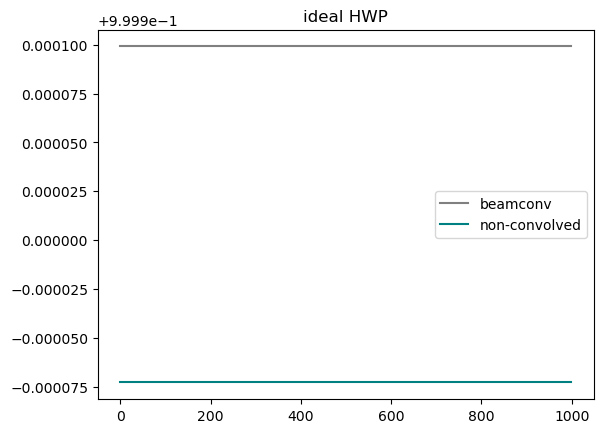

In [11]:
plt.plot(tod1, label='beamconv', color='gray')
plt.plot(d1, label='non-convolved', color='teal')
plt.title('ideal HWP')
plt.legend()
plt.show()

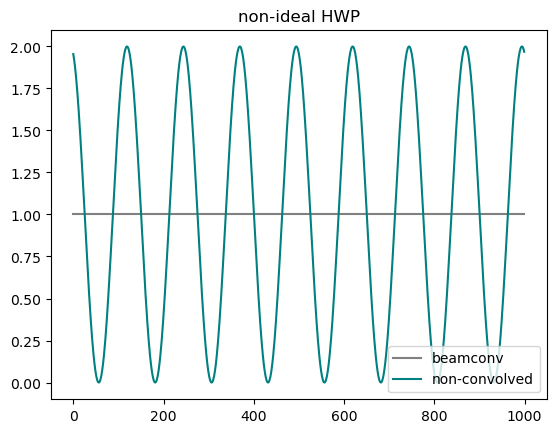

In [12]:
plt.plot(tod2, label='beamconv', color='gray')
plt.plot(d2, label='non-convolved', color='teal')
plt.title('non-ideal HWP')
plt.legend()
plt.show()

# Trying to feed TOD to beamconv's map-maker

In [13]:
from beamconv import Beam, ScanStrategy, tools
import qpoint as qp

mueller=mueller2

# set up beam and HWP mueller matrix (identity, i.e. no HWP)
beam = Beam(btype='Gaussian', fwhm=fwhm_arcmin, lmax=lmax)
beam.hwp_mueller = mueller

nsamp = ptg.shape[0]
duration = 1       #scan duration in seconds
sample_rate = nsamp  #samples per second

ptg = np.empty((nptg,3))
ptg[:,0]=np.arange(nptg)*1e-2    # theta
ptg[:,1]=np.arange(nptg)*1e-2    # phi
ptg[:,2]=np.arange(nptg)*1e-2    # psi

# from (theta,phi) to (ra,dec) convention
# also, all angles are converted in degrees
ra = np.degrees(ptg[:,1])
dec = 90. - np.degrees(ptg[:,0])
psi = np.degrees(ptg[:,2])

# calculate the quaternion
q_bore_array = qp.QPoint().radecpa2quat(ra, dec, psi)

def ctime_test(**kwargs):
    start = kwargs.pop('start')
    end = kwargs.pop('end')
    nsamp = end - start
    ctime0 = 0
    ctime = ctime0 + sample_rate*np.arange(nsamp)
    return ctime
    
def q_bore_test(**kwargs):
    start = kwargs.pop('start')
    end = kwargs.pop('end')
    return q_bore_array[start:end]
   
SS = ScanStrategy(duration=duration, sample_rate=sample_rate, external_pointing=True, use_l2_scan=False)
SS.add_to_focal_plane(beam, combine=False)
SS.set_hwp_mod(mode='stepped', freq=sample_rate, angles=hwp_angles*180/np.pi)
SS.allocate_maps(nside=nside)
SS.scan_instrument_mpi(slm, save_tod=False, ctime_func=ctime_test, q_bore_func=q_bore_test,
                  ctime_kwargs={'useless':0}, q_bore_kwargs={'useless':0})

np.random.seed(seed=10)
tod = np.random.rand(nsamp)

SS.bin_tod(SS.beams[0][0], tod=tod2, start=0, end=nsamp)
out_maps, cond, proj = SS.solve_for_map(return_proj = True)
print(out_maps[0,0])

Scanning with 1 detectors
[rank 000]:	Working on chunk 000: samples 0-1000
0.9997934098524097


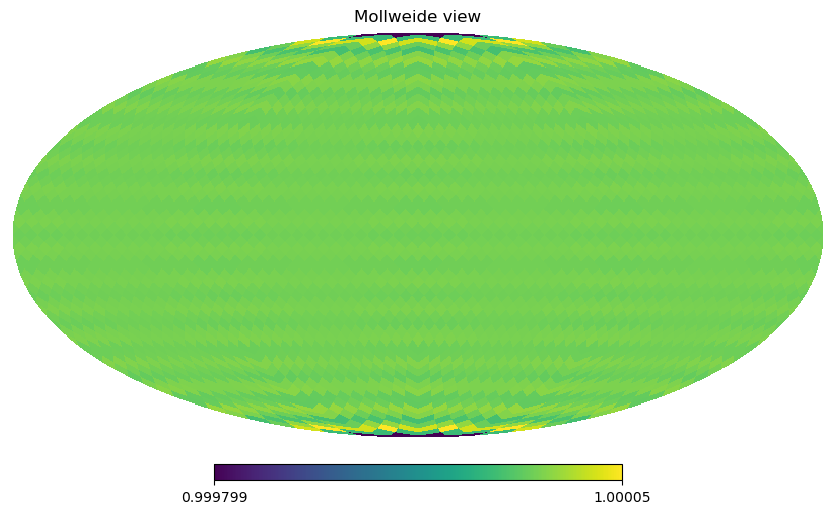

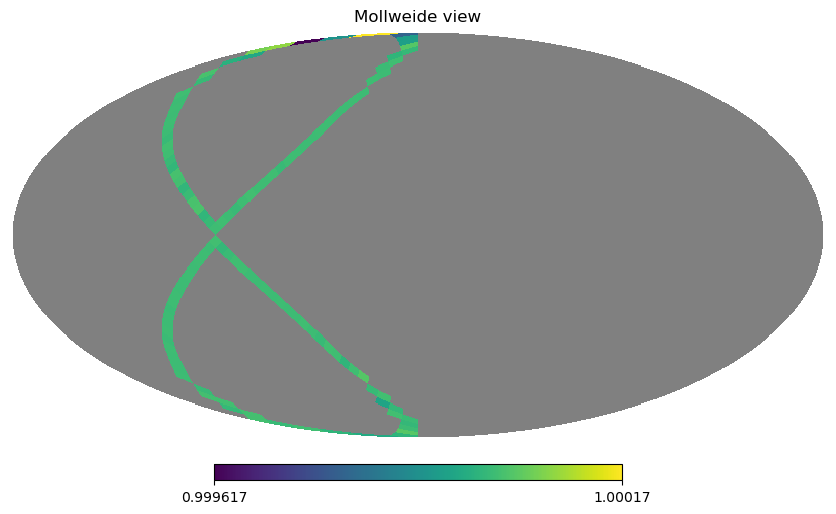

In [14]:
hp.mollview(maps[0])
hp.mollview(out_maps[0])